In [1]:
import datetime
import gc
import glob
import io
import os
import random
import re
import tarfile

import flash
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn
import torch
import torchvision
from ipynb.fs.defs.dcgan import fix_seed, init_weight
from PIL import Image
from sklearn.datasets import fetch_openml
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
/usr/local/lib/python3.10/dist-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.
  if not hasattr(numpy, tp_name):
2024-01-09 16:58:42.114618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-09 16:58:42.114674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-09 16:58:42.116681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:15

In [2]:
SEED = 2913
fix_seed(SEED)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Self-Attention GAN

Self-Attention GAN(SAGAN)は、`Self-Attention`, `Pointwise Convolution`, `Spectral Normalization`の3つの技術を軸に構成される。これらの内容は難しいため、書籍からさらに説明を深めて具体例を用いながら説明してく。

## Self-Attention

GANの`ConvTranspose2d`の課題は、入力データの局所的な情報しか使われないことであった。

例えば以下のように`kernel_size=2`の場合には、入力の各ピクセルは、出力の2x2のピクセルにしか影響を与えない。逆に、出力の各ピクセルはせいぜい2つの入力ピクセルからしか影響を受けない。

したがって、入力の全体情報が使われていない。この問題に対処するためにSelf-Attentionが応用される。

In [4]:
x = torch.rand(1, 2, 2)
print("--------x--------")
display(x)
t = torch.nn.ConvTranspose2d(1, 1, kernel_size=2)
print("--------weight--------")
display(t.weight)
print("--------bias--------")
display(t.bias)
print("--------output--------")
display(t(x))

--------x--------


tensor([[[0.5101, 0.5928],
         [0.2165, 0.4792]]])

--------weight--------


Parameter containing:
tensor([[[[ 0.3227, -0.1570],
          [-0.0849,  0.0605]]]], requires_grad=True)

--------bias--------


Parameter containing:
tensor([-0.1316], requires_grad=True)

--------output--------


tensor([[[ 0.0331, -0.0203, -0.2246],
         [-0.1050, -0.0304, -0.1709],
         [-0.1499, -0.1592, -0.1026]]], grad_fn=<SqueezeBackward1>)

Self-Attentionでは、あるレイヤーに入力する前に、画像を以下のように変換する。

$
y = x + \gamma o
$

xは入力画像、$\gamma$は係数(学習時に決定される)、$o$はSelf-Attention Mapである。

Self-Attention Mapには、「大域的な」情報が含まれている。ここが少しわかりづらいので、以下、具体的な計算例を見ていきながら、Self-Attention Mapについて理解することにする。

*Todo:xとoを足すと色々と情報が失われる気がする。なぜ別々に入力しないのか？*

In [5]:
def show_image(img, gray=False, scale=2):
    # set figsize
    plt.figure(figsize=(scale * img.shape[-1], scale * img.shape[-2]))
    channel = img.shape[1]
    if gray:
        plt.gray()
        plt.imshow(img.squeeze(0))
    else:
        plt.imshow(img.squeeze(0).permute(1, 2, 0))

    if not gray:
        for i in range(channel):
            for j in range(img.shape[2]):
                for k in range(img.shape[3]):
                    color = (
                        "black" if torch.mean(img[0, :, j, k]).item() > 0.5 else "white"
                    )
                    plt.text(
                        k,
                        j + 0.2 * (i - 1),
                        "{:.2f}".format(img[0, i, j, k].item()),
                        ha="center",
                        va="center",
                        fontsize=8 * scale,
                        color=color,
                    )
    if gray:
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                color = (
                    "black"
                    if (img[0, j, k].item() - torch.min(img).item())
                    / (torch.max(img).item() - torch.min(img).item())
                    > 0.5
                    else "white"
                )
                plt.text(
                    k,
                    j,
                    "{:.2f}".format(img[0, j, k].item()),
                    ha="center",
                    va="center",
                    fontsize=8 * scale,
                    color=color,
                )
    plt.show()

以下の例では、入力xは(1,3,4,4)のサイズのテンソルであるとする。dim=0はバッチサイズ、dim=1はRGBのチャネルの次元、dim=2,3は画像の高さ・幅の次元となっている。

torch.Size([1, 3, 4, 4])

tensor([[[[0.0628, 0.7454, 0.8150, 0.0715],
          [0.6928, 0.7567, 0.1962, 0.4020],
          [0.5507, 0.7687, 0.0569, 0.4768],
          [0.7651, 0.6822, 0.3735, 0.4918]],

         [[0.5413, 0.1302, 0.8143, 0.5295],
          [0.8440, 0.4136, 0.2326, 0.5870],
          [0.2678, 0.6414, 0.6395, 0.3765],
          [0.8434, 0.1848, 0.8551, 0.6668]],

         [[0.2385, 0.7596, 0.3553, 0.2670],
          [0.0583, 0.8167, 0.7751, 0.2422],
          [0.2972, 0.4304, 0.4130, 0.0781],
          [0.1851, 0.5676, 0.6343, 0.0206]]]])

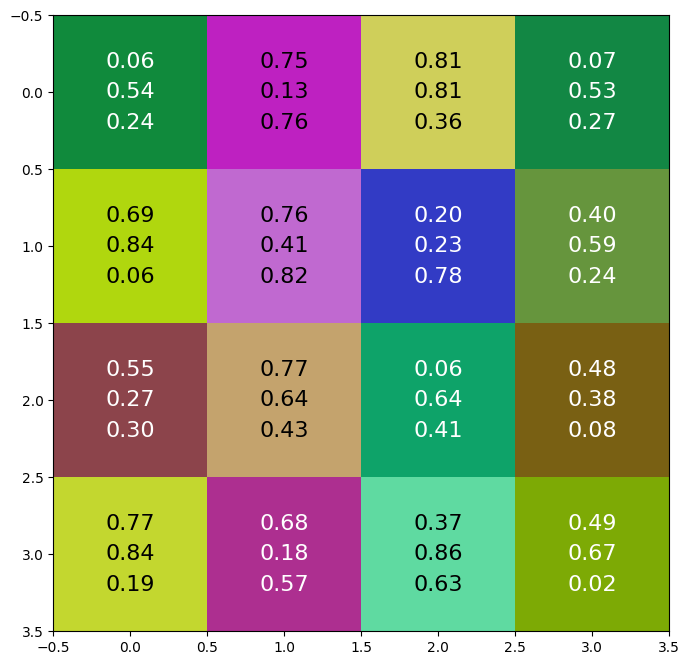

In [6]:
img_size = 4
# C x H x W
x = torch.rand(1, 3, img_size, img_size)
display(x.shape)
display(x)
show_image(x)

まず、チャネルの次元を残しつつ、高さ・幅の次元を1つにすることで、サイズが(1,3,16)のテンソルx_flattenを作成する。

`x_flatten[0,:,i]`は、各indexのRGBのチャネル情報となる。

ここで、以降の説明をわかりやすくするため、`x_flatten`でフラット化された各ピクセルのチャネル情報を以下のように表すとする。

$
x\_flatten_i = \begin{pmatrix} r_i \\ g_i \\ b_i \end{pmatrix}
$

--------x_flatten--------


torch.Size([1, 3, 16])

tensor([[[0.0628, 0.7454, 0.8150, 0.0715, 0.6928, 0.7567, 0.1962, 0.4020,
          0.5507, 0.7687, 0.0569, 0.4768, 0.7651, 0.6822, 0.3735, 0.4918],
         [0.5413, 0.1302, 0.8143, 0.5295, 0.8440, 0.4136, 0.2326, 0.5870,
          0.2678, 0.6414, 0.6395, 0.3765, 0.8434, 0.1848, 0.8551, 0.6668],
         [0.2385, 0.7596, 0.3553, 0.2670, 0.0583, 0.8167, 0.7751, 0.2422,
          0.2972, 0.4304, 0.4130, 0.0781, 0.1851, 0.5676, 0.6343, 0.0206]]])

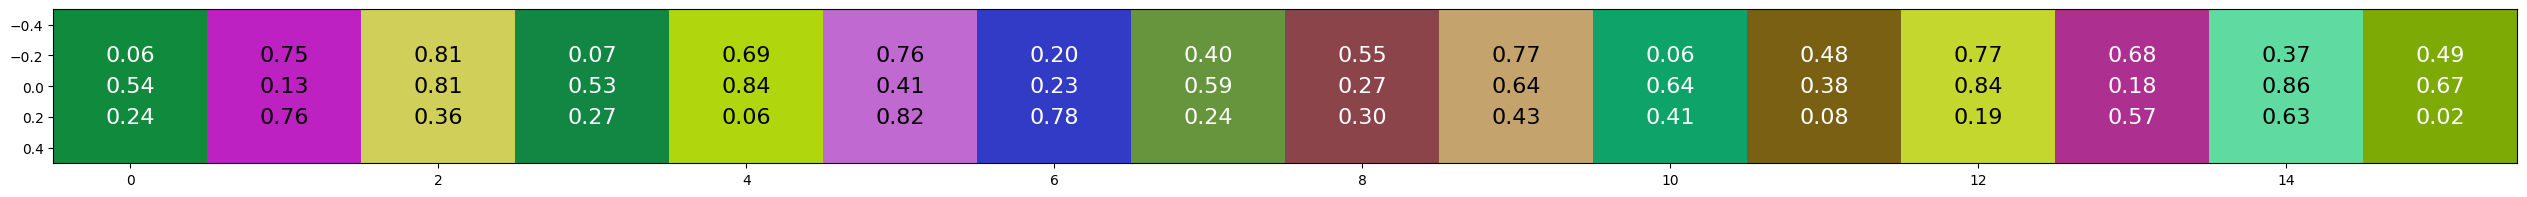

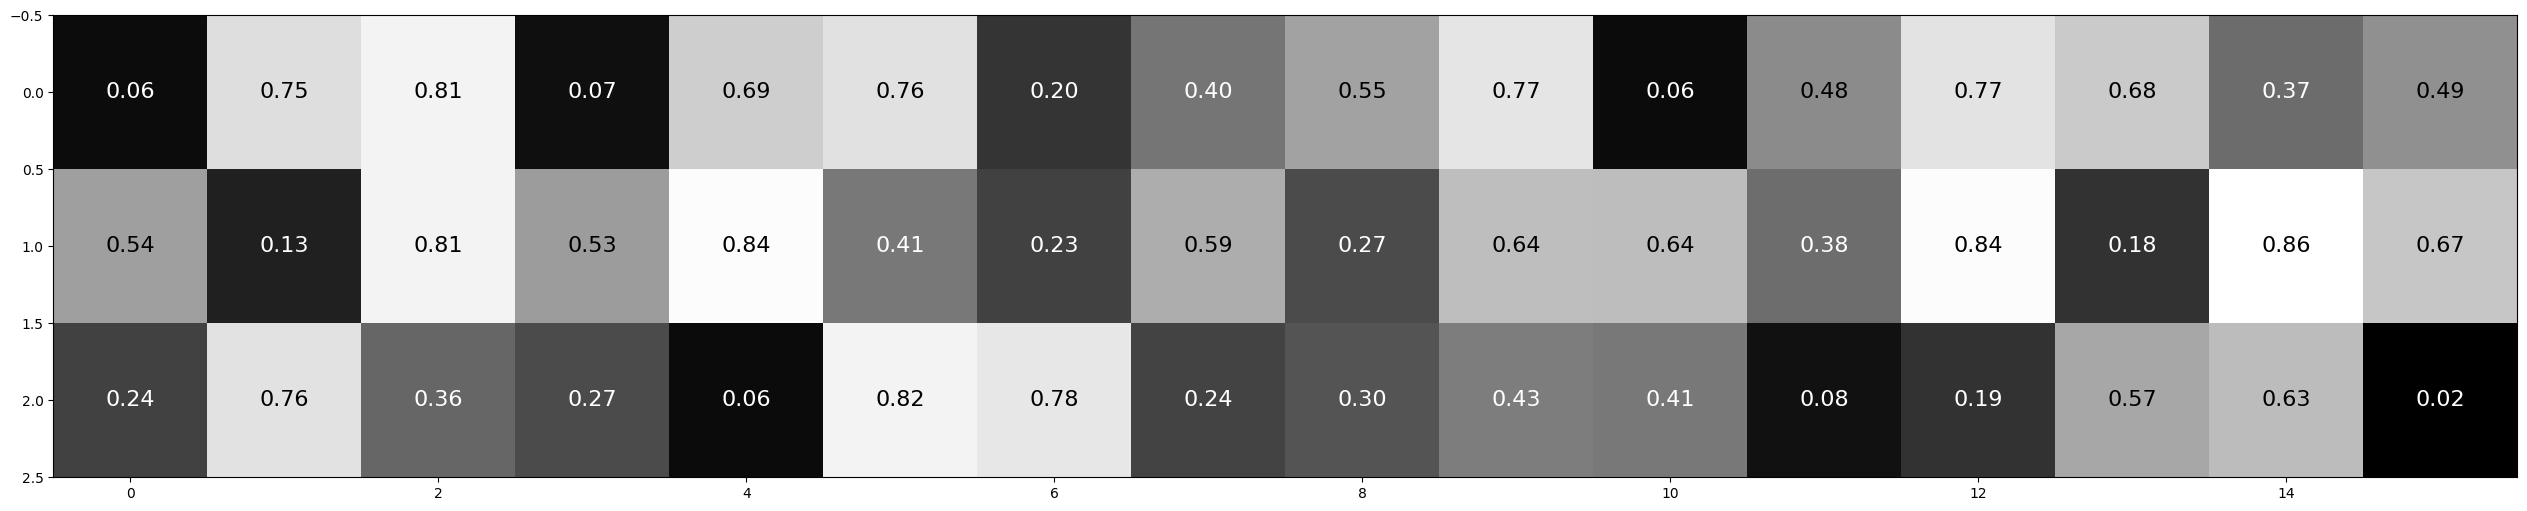

In [7]:
x_flatten = x.reshape(1, x.shape[1], -1)
print("--------x_flatten--------")
display(x_flatten.shape)
display(x_flatten)
show_image(x_flatten.unsqueeze(2))
show_image(x_flatten, gray=True)

`x_flatten`の転置行列`x_flatten_t`を作成する。

--------x_flatten_t--------


torch.Size([1, 16, 3])

tensor([[[0.0628, 0.5413, 0.2385],
         [0.7454, 0.1302, 0.7596],
         [0.8150, 0.8143, 0.3553],
         [0.0715, 0.5295, 0.2670],
         [0.6928, 0.8440, 0.0583],
         [0.7567, 0.4136, 0.8167],
         [0.1962, 0.2326, 0.7751],
         [0.4020, 0.5870, 0.2422],
         [0.5507, 0.2678, 0.2972],
         [0.7687, 0.6414, 0.4304],
         [0.0569, 0.6395, 0.4130],
         [0.4768, 0.3765, 0.0781],
         [0.7651, 0.8434, 0.1851],
         [0.6822, 0.1848, 0.5676],
         [0.3735, 0.8551, 0.6343],
         [0.4918, 0.6668, 0.0206]]])

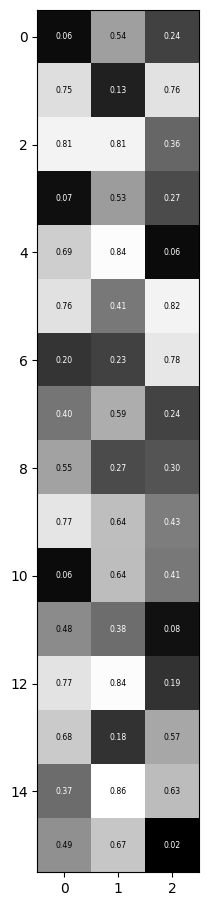

In [8]:
x_flatten_t = x_flatten.transpose(1, 2)
print("--------x_flatten_t--------")
display(x_flatten_t.shape)
display(x_flatten_t)
show_image(x_flatten_t, gray=True, scale=0.7)

`x_flatten_t`と`x_flatten`の積をとって、`s`を作成する。この`s`は[グラム行列](https://ja.wikipedia.org/wiki/%E3%82%B0%E3%83%A9%E3%83%A0%E8%A1%8C%E5%88%97)と呼ばれる。グラム行列は、以下のような性質を持つ。

- 正方行列(ここでのサイズは`(16,16)`)
- 正則行列
- 対称行列
- $s_{i,j}$は、$x\_{flatten}_i \cdot x\_{flatten}_j$となる。すなわち、`s`の各成分は、元の画像のピクセルのチャネル情報ベクトル同士に対して内積をとったものになっている。
- なお、チャネル情報の内積を取っているのだから、内積の計算に使用した2つのチャネルベクトルの大きさで内積値を割ることにより、$\cos{\theta_{i,j}} = x\_{flatten}_i \cdot x\_{flatten}_j / (|x\_{flatten}_i|\cdot|x\_{flatten}_j|)$となるから、2つのチャネル情報ベクトルの成す角が計算される。これは相関係数を計算していることに他ならない。
- 上記より、`s`には各チャネル情報の類似度のような情報が含まれていることがわかる。

torch.Size([1, 16, 16])

tensor([[[0.3538, 0.2985, 0.5767, 0.3548, 0.5143, 0.4662, 0.3231, 0.4008,
          0.2504, 0.4981, 0.4483, 0.2524, 0.5487, 0.2782, 0.6376, 0.3967],
         [0.2985, 1.1495, 0.9834, 0.3251, 0.6706, 1.2383, 0.7653, 0.5601,
          0.6711, 0.9834, 0.4394, 0.4638, 0.8206, 0.9637, 0.8715, 0.4691],
         [0.5767, 0.9834, 1.4535, 0.5843, 1.2727, 1.2437, 0.6247, 0.8917,
          0.7724, 1.3017, 0.7139, 0.7230, 1.3760, 0.9081, 1.2261, 0.9511],
         [0.3548, 0.3251, 0.5843, 0.3568, 0.5120, 0.4912, 0.3442, 0.4042,
          0.2605, 0.5095, 0.4530, 0.2543, 0.5507, 0.2982, 0.6488, 0.3937],
         [0.5143, 0.6706, 1.2727, 0.5120, 1.1958, 0.9210, 0.3775, 0.7881,
          0.6249, 1.0990, 0.6033, 0.6527, 1.2527, 0.6617, 1.0175, 0.9047],
         [0.4662, 1.2383, 1.2437, 0.4912, 0.9210, 1.4107, 0.8777, 0.7448,
          0.7702, 1.1985, 0.6449, 0.5804, 1.0789, 1.0562, 1.1543, 0.6648],
         [0.3231, 0.7653, 0.6247, 0.3442, 0.3775, 0.8777, 0.6934, 0.4032,
          0.4007, 0.6336, 0.4801

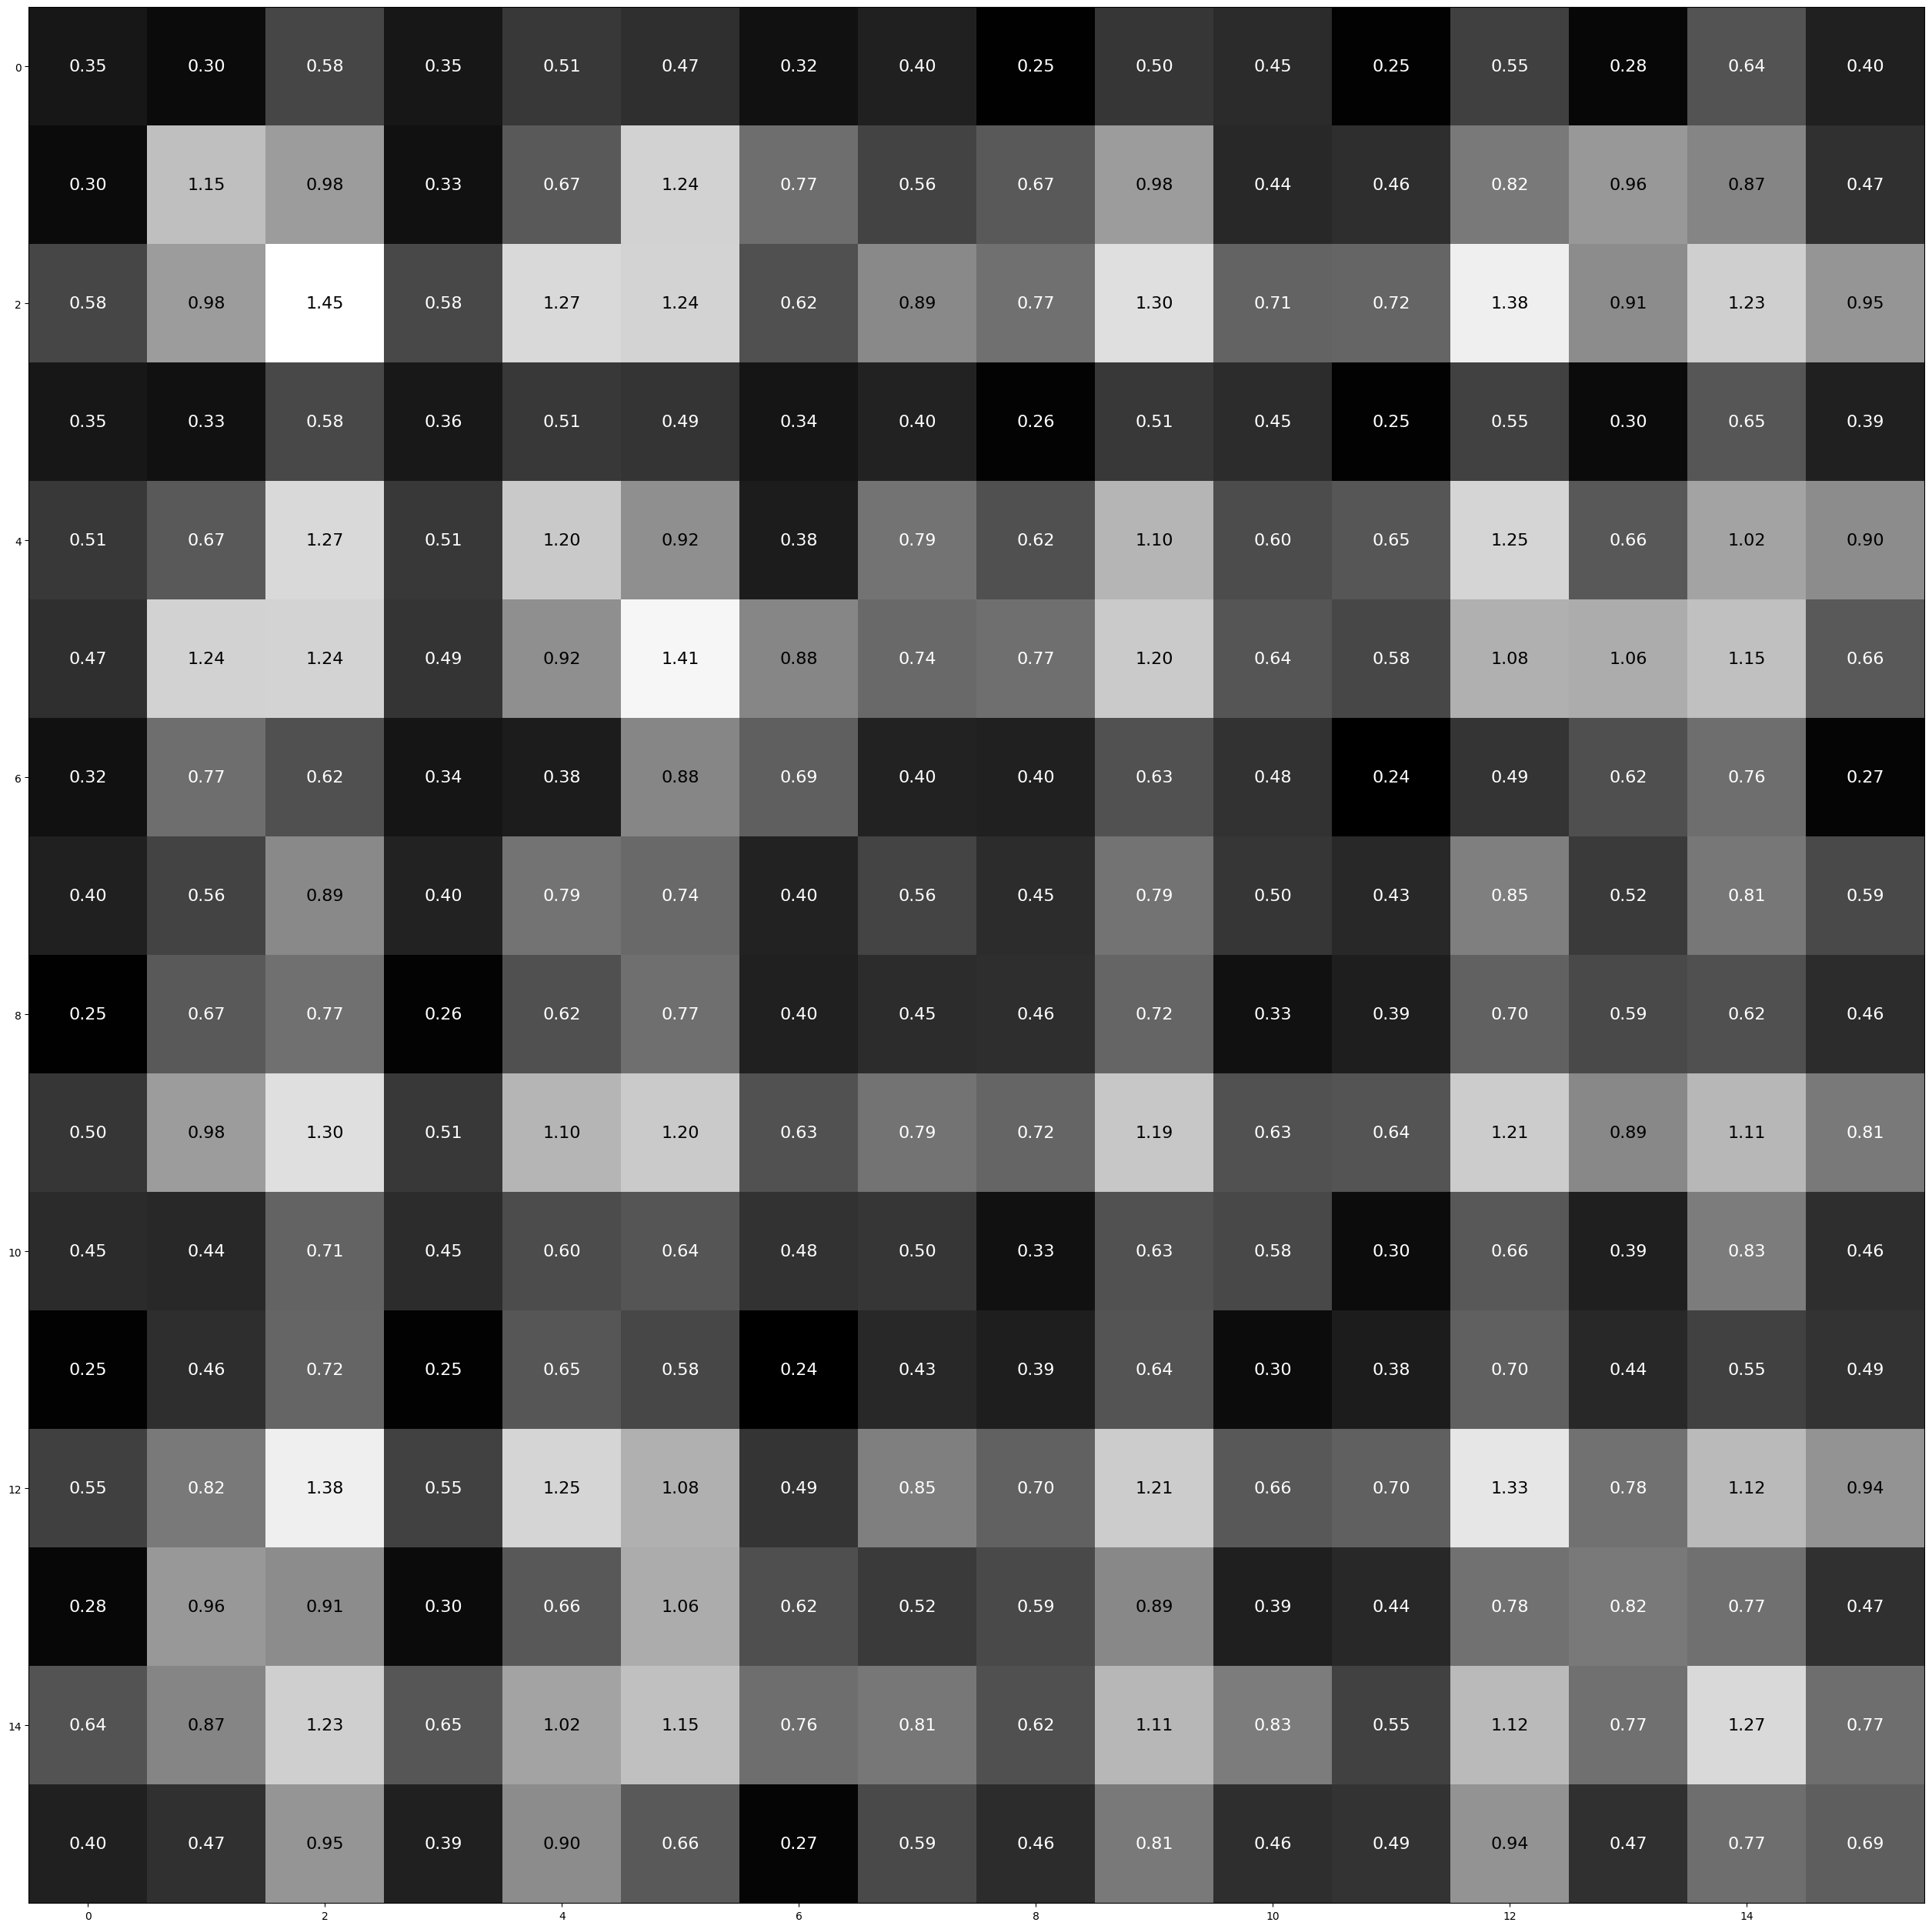

In [9]:
s = torch.bmm(x_flatten_t, x_flatten)
display(s.shape)
display(s)
show_image(s, gray=True)

本当に`s`の各成分がチャネル情報の内積になっているのかを確認する。

In [10]:
eps = 1e-5
for i in range(img_size * img_size):
    for j in range(img_size * img_size):
        diff = abs(
            torch.dot(x_flatten[0, :, i], x_flatten[0, :, j]).item() - s[0, i, j].item()
        )
        assert diff < eps

行方向に対してSoftmax関数による正規化を行う。これは、Attention Mapを転置したものになる(まだ`o`(**Self-**Attention Mapではないので注意)。

*Todo:この正規化は必須？*

In [11]:
m = torch.nn.Softmax(dim=-2)
attention_map_t = m(s)
print("--------attention_map_t--------")
display(attention_map_t.shape)
# display(attention_map_t)
# show_image(attention_map_t, gray=True)

--------attention_map_t--------


torch.Size([1, 16, 16])

--------attention_map--------


torch.Size([1, 16, 16])

tensor([[[0.0585, 0.0554, 0.0732, 0.0586, 0.0687, 0.0655, 0.0568, 0.0614,
          0.0528, 0.0676, 0.0643, 0.0529, 0.0711, 0.0543, 0.0778, 0.0611],
         [0.0390, 0.0914, 0.0774, 0.0401, 0.0566, 0.0999, 0.0623, 0.0507,
          0.0567, 0.0774, 0.0450, 0.0461, 0.0658, 0.0759, 0.0692, 0.0463],
         [0.0402, 0.0604, 0.0967, 0.0405, 0.0807, 0.0784, 0.0422, 0.0551,
          0.0489, 0.0831, 0.0461, 0.0466, 0.0895, 0.0560, 0.0770, 0.0585],
         [0.0581, 0.0564, 0.0731, 0.0582, 0.0680, 0.0666, 0.0575, 0.0610,
          0.0529, 0.0678, 0.0641, 0.0525, 0.0707, 0.0549, 0.0779, 0.0604],
         [0.0444, 0.0520, 0.0949, 0.0443, 0.0878, 0.0667, 0.0388, 0.0584,
          0.0496, 0.0797, 0.0486, 0.0510, 0.0930, 0.0515, 0.0735, 0.0657],
         [0.0385, 0.0834, 0.0838, 0.0395, 0.0607, 0.0991, 0.0581, 0.0509,
          0.0522, 0.0801, 0.0461, 0.0432, 0.0711, 0.0695, 0.0767, 0.0470],
         [0.0505, 0.0785, 0.0682, 0.0515, 0.0533, 0.0879, 0.0731, 0.0547,
          0.0545, 0.0688, 0.0590

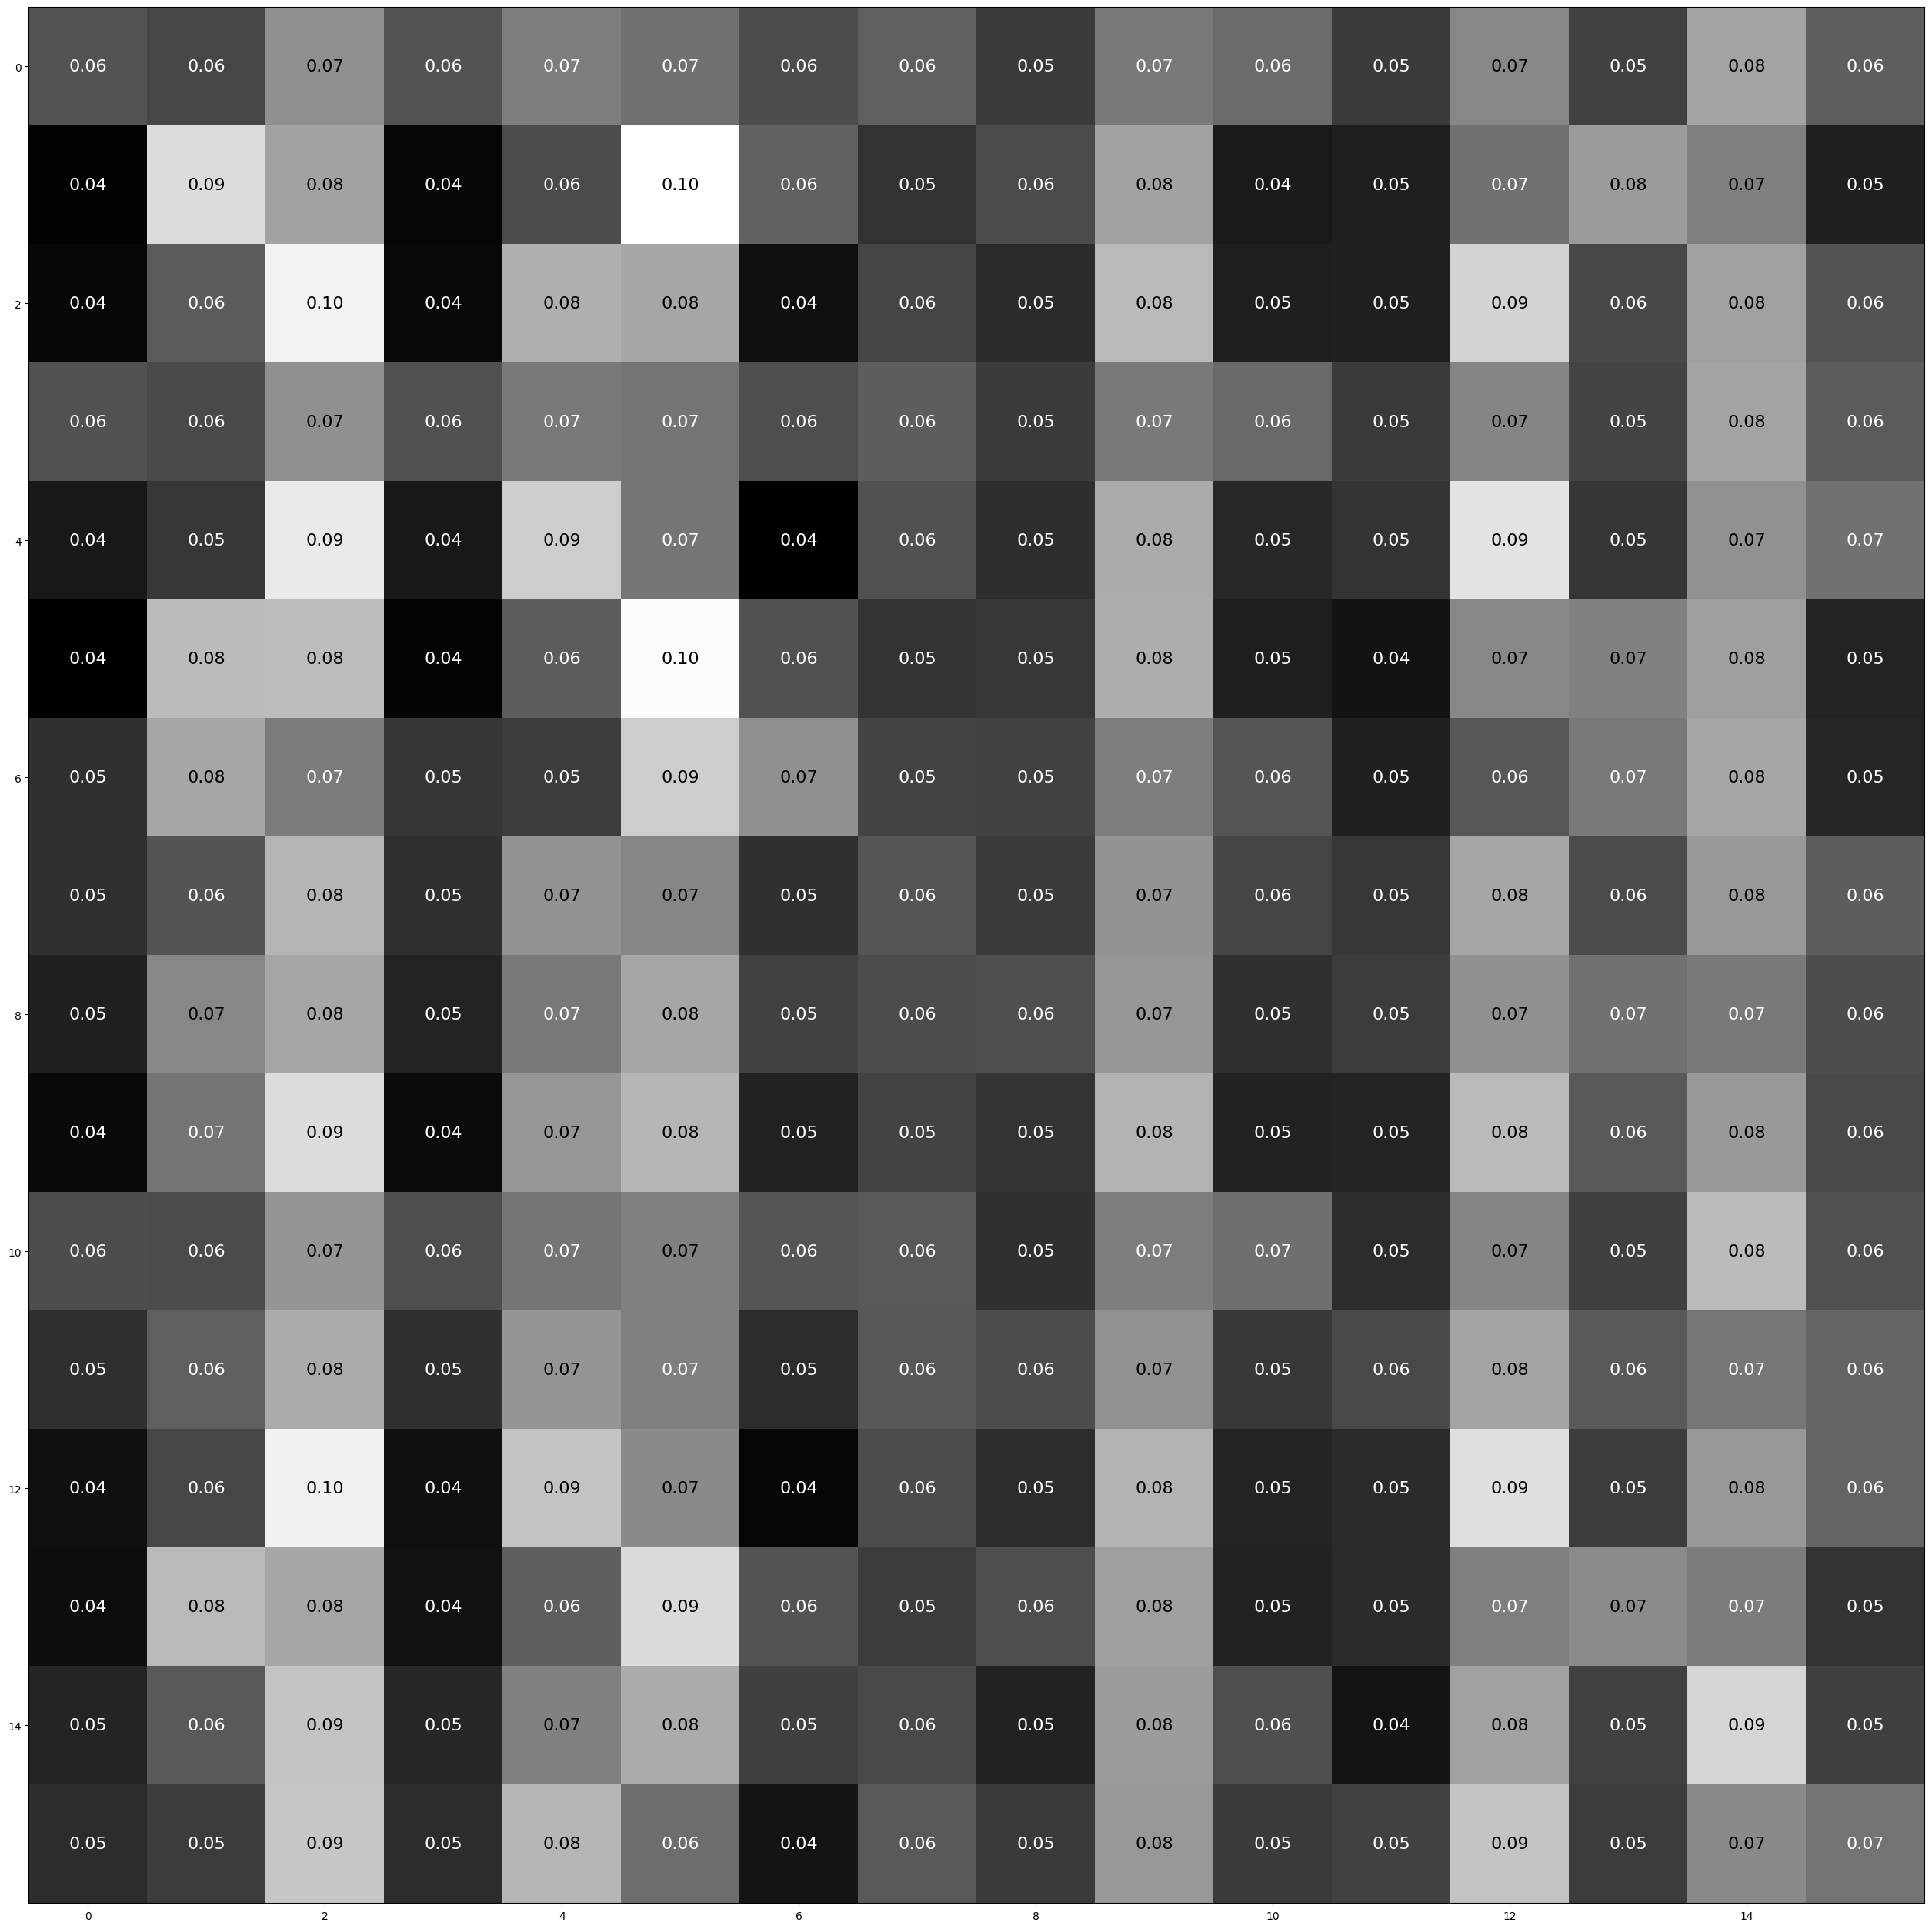

In [12]:
attention_map = attention_map_t.transpose(1, 2)
print("--------attention_map--------")
display(attention_map.shape)
display(attention_map)
show_image(attention_map, gray=True)

最後に、x_flattenとAttention Mapの積を取る。これにより、各ピクセルは、そのピクセルと同じような色が多ければ大きくなる。

--------o--------


torch.Size([1, 3, 4, 4])

tensor([[[[0.5023, 0.5501, 0.5547, 0.5029],
          [0.5462, 0.5518, 0.5137, 0.5260],
          [0.5346, 0.5511, 0.5031, 0.5290],
          [0.5512, 0.5447, 0.5272, 0.5317]],

         [[0.5597, 0.5213, 0.5766, 0.5583],
          [0.5859, 0.5373, 0.5265, 0.5641],
          [0.5443, 0.5638, 0.5605, 0.5570],
          [0.5829, 0.5310, 0.5684, 0.5754]],

         [[0.3841, 0.4350, 0.3869, 0.3863],
          [0.3670, 0.4294, 0.4285, 0.3845],
          [0.3983, 0.3967, 0.3924, 0.3805],
          [0.3751, 0.4197, 0.4018, 0.3688]]]])

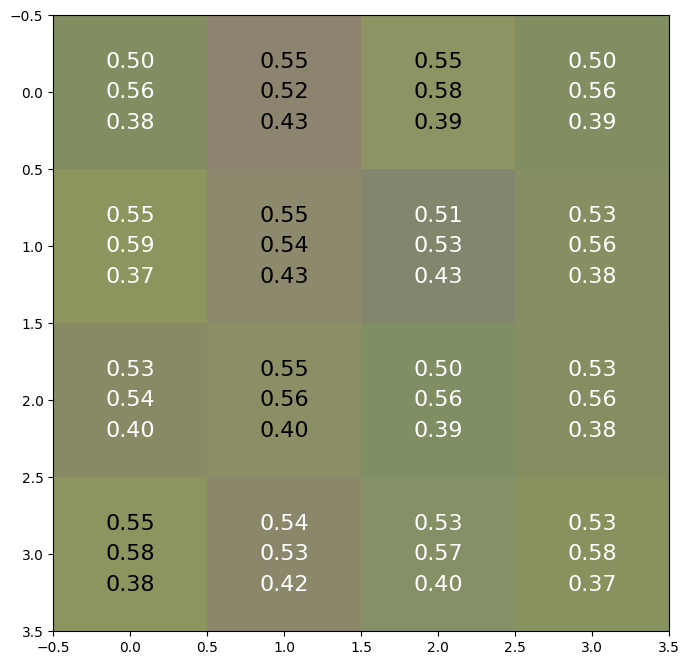

In [13]:
o = torch.bmm(x_flatten, attention_map_t)
# make the size of o same as x
o = o.reshape(1, x.shape[1], x.shape[2], x.shape[3])
print("--------o--------")
display(o.shape)
display(o)
show_image(o)

ここまでの処理をクラスとして実装する。書籍とは変えて、SelfAttentionクラスにはSelfAttentionの実装のみを書く(Pointwise Convは別で書く)。

In [14]:
class PrimitiveSelfAttention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = torch.nn.Softmax(dim=-2)
        self.gamma = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x_flatten = x.view(x.shape[0], x.shape[1], -1)
        x_flatten_t = x_flatten.permute(0, 2, 1)
        s = torch.bmm(x_flatten_t, x_flatten)
        attention_map_t = self.softmax(s)
        attention_map = attention_map_t.permute(0, 2, 1)
        o = torch.bmm(x_flatten, attention_map_t).view(
            x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        )
        return x + self.gamma * o, attention_map

Lenaの画像に対して、Attention Mapを確認してみる。

Lenaの画像テンソルのサイズは、(3,64,64)にしている。したがって、Attention Mapのサイズは、$(64*64, 64*64)=(4096,4096)$になる。Attention Mapのサイズはかなり大きくなり、入力画像のサイズが大きすぎる時にはメモリに乗らなくなるので注意。

下記の実装で示している通り、`attention_map[0,:,x*img_size+y]`の1次元ベクトルを2次元ベクトルに変換すると、(x,y)に対応したAttentionを見るおがことができる。下図の可視化では、ランダムに選ばれた"X"のマーカーに対するAttentionをヒートマップで表示している。オリジナルの画像と見比べると、マーカーの位置と同じような色の部分が濃く(より赤色に)表示されていることがわかる。

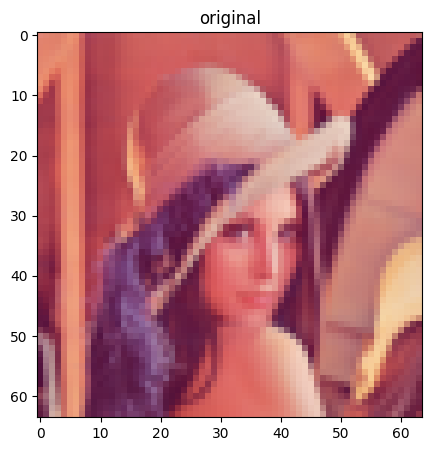

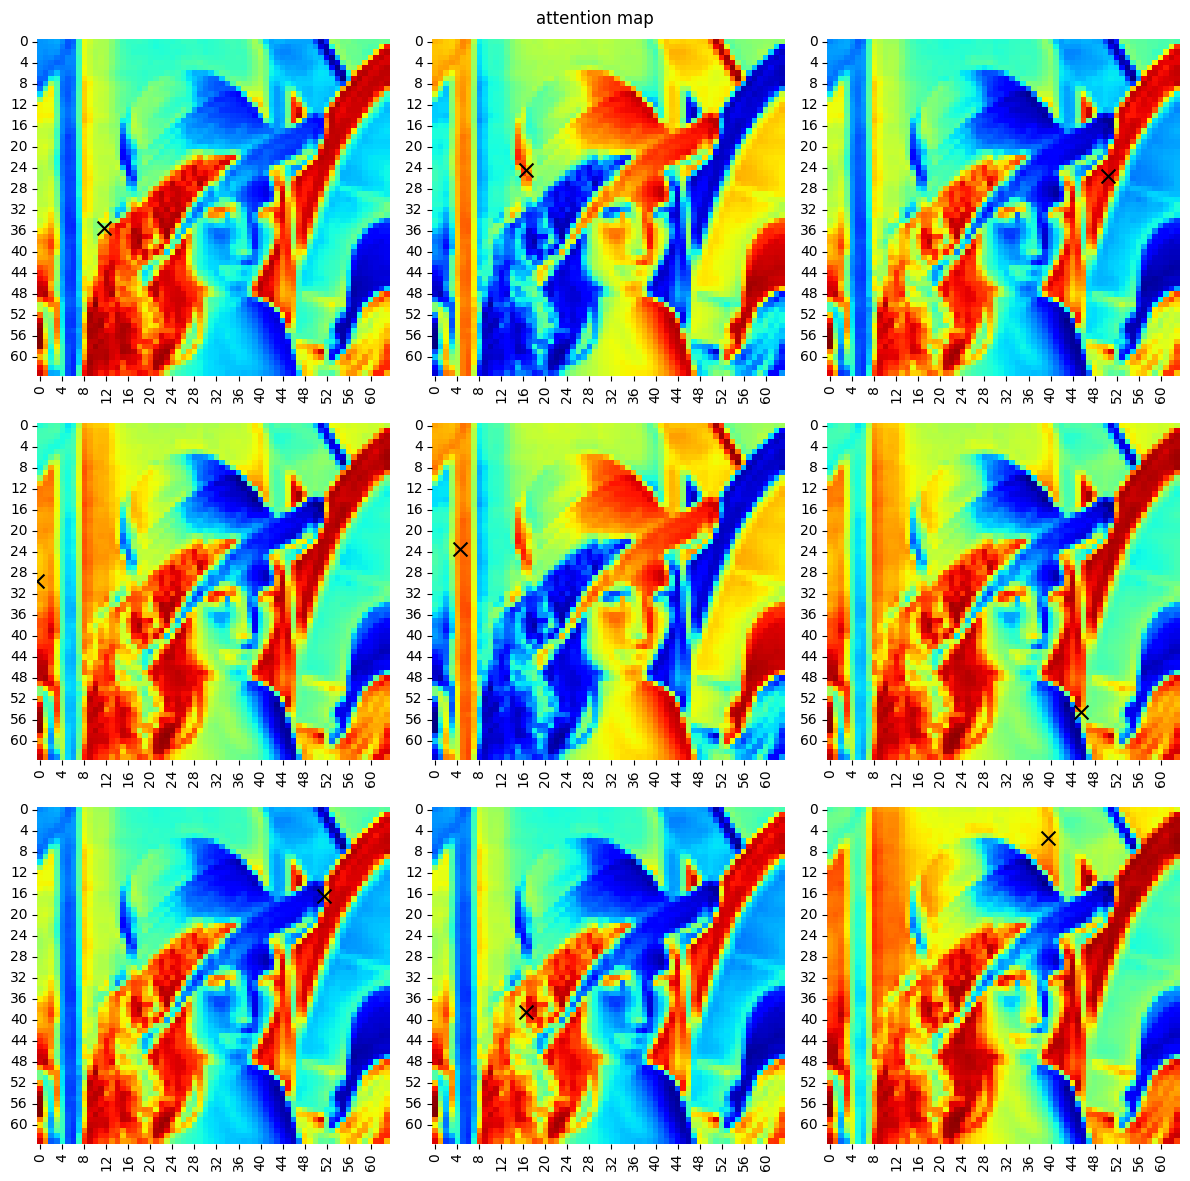

In [15]:
# download lena from https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png
if not os.path.exists("data/lena.png"):
    url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png"
    response = requests.get(url)
    with open("data/lena.png", "wb") as file:
        file.write(response.content)

img_size = 64
# open lena and convert it to tensor
lena = Image.open("data/lena.png")
lena = torchvision.transforms.Resize((img_size, img_size))(lena)
lena = torchvision.transforms.ToTensor()(lena).to(device)
self_attention = PrimitiveSelfAttention().to(device)
_, attention_map = self_attention(lena.unsqueeze(0))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(lena.detach().cpu().permute(1, 2, 0))
ax.set_title("original")
plt.show()

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("attention map")
for ax in axes.flatten():
    # random sample from0~img_size
    x = random.randint(0, img_size - 1)
    y = random.randint(0, img_size - 1)
    # ax.imshow(attention_map[0, :, x*img_size+y].detach().cpu().reshape(img_size, img_size))
    sns.heatmap(
        attention_map[0, :, x * img_size + y]
        .detach()
        .cpu()
        .reshape(img_size, img_size),
        ax=ax,
        cbar=False,
        cmap="jet",
    )
    # highlight x,y
    ax.scatter(y, x, c="black", s=100, marker="x")
plt.tight_layout()
plt.show()

In [16]:
del lena, attention_map, self_attention
gc.collect()
torch.cuda.empty_cache()

## Pointwise Convolution

Pointwise Convolutionはkernel_sizeが1のあた畳み込み。画像の場合であれば、高さ・幅の次元は変化させないままに、チャネルの次元を変えることができる。kernel_size=1なので、周辺情報を含めた特徴量の作成はできないものの、チャネルの出力次元を入力次元を小さくすることにより、次元の圧縮を行うことができる。

先ほどのLenaの画像を用いたSelf Attentionでも説明した通り、Attention Mapのサイズはかなり大きくなる。そこで、Pointwise Convolutionによる次元圧縮を行うことにより、Attention Mapのサイズを小さくしつつ、Self-Attention Layerを適用できることがポイントになる。

Self-Attentionでは、`key`, `query`, `value`という用語が一般的らしい。基本的な操作は上記と同じであるものの、`key`, `query`, `value`のそれぞれに対してPointwise Convolutionを行うことがポイント。詳細は下図。

```mermaid
flowchart LR;

input --[Pointwise Conv]--> key ----> dot1([x])
input --[Pointwise Conv]--> query --[transpose]-->query_t ----> dot1 --[Softmax]--> attention_map_t ----> dot2([x]) 
input --[Pointwise Conv]--> value ----> dot2 ----> o

```

In [17]:
class SelfAttention(torch.nn.Module):
    def __init__(self, in_channels, feat_channels):
        super().__init__()
        self.softmax = torch.nn.Softmax(dim=-2)
        self.gamma = torch.nn.Parameter(torch.zeros(1))
        self.convs = torch.nn.ModuleDict(
            {
                key: torch.nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=feat_channels if key != "value" else in_channels,
                    kernel_size=1,
                )
                for key in ["key", "query", "value"]
            }
        )

    def forward(self, x):
        batch_size, _, height, width = x.shape
        key = self.convs["key"](x).view(batch_size, -1, height * width)
        query = (
            self.convs["query"](x).view(batch_size, -1, height * width).permute(0, 2, 1)
        )
        s = torch.bmm(query, key)

        attention_map_t = self.softmax(s)
        attention_map = attention_map_t.permute(0, 2, 1)

        value = self.convs["value"](x).view(batch_size, -1, height * width)
        o = torch.bmm(value, attention_map_t).view(batch_size, -1, height, width)

        return x + self.gamma * o, o, attention_map

In [18]:
_batch_size = 4
_input = torch.rand(_batch_size, 3, 64, 64)
_self_attention = SelfAttention(3, 1)
_output, _o, _attention_map = _self_attention(_input)
assert _output.shape == _input.shape
assert _o.shape == _input.shape
assert _attention_map.shape == (_batch_size, 64 * 64, 64 * 64)
del _input, _output, _o, _attention_map, _self_attention
gc.collect()
torch.cuda.empty_cache()

## Spectral Normalization

`wgan.ipynb`では、Discriminatorのリプシッツ連続性が重要であると述べた。まず、リプシッツ連続性について理解する。

ある関数$f(x)$がリプシッツ連続であるとは、任意の$x_1, x_2$に対して、$|f(x_1) - f(x_2)| \leq K |x_1 - x_2|$が成立するリプシッツ定数$K$が存在することをいう。これを定性的にとらえると、入力の変化に対して出力の変化は上限があるということになる。

具体例で考えると、$f(x)=x^2$はリプシッツ連続ではないが、$f(x)=\sqrt(x)$はリプシッツ連続である。$x^2$は$x$が大きくなるにつれて急激に変化するものの、$\sqrt(x)$はそうではないので直感的に正しそうなことがわかると思う。なお、証明も難しくない。

Discriminator, Generatorがリプシッツ連続であれば、入力が多少変化したとしても出力が大きく変化することはない。そこで、これらをリプシッツ連続にするために、Spectral NormalizationをGenerator, Discriminatorの重みに適用する。これにより、リプシッツ定数を1以下に制限することができる。

Pytorchでは、`torch.nn.utils.spectral_norm`を使用することで実装が簡単になる。

以下の実装では、WGANと同様にWasserstein Lossを使用するので、出力は書籍と異なる。

In [19]:
class Deconv2d(torch.nn.Sequential):
    def __init__(self, in_channels, out_channels, with_batch_norm=True, **kwargs):
        super().__init__()
        self.add_module(
            "ConvTranspose2d",
            torch.nn.utils.spectral_norm(
                torch.nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
            ),
        )
        if with_batch_norm:
            self.add_module("BatchNorm2d", torch.nn.BatchNorm2d(out_channels))
        self.add_module("ReLU", torch.nn.ReLU(inplace=True))

In [20]:
class Generator(torch.nn.Sequential):
    def __init__(self, z_dim, image_size):
        super().__init__()

        self.layers = torch.nn.ModuleList(
            [
                Deconv2d(z_dim, image_size * 8, kernel_size=4, stride=1),
                Deconv2d(
                    image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1
                ),
                Deconv2d(
                    image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1
                ),
                SelfAttention(image_size * 2, image_size * 2 // 8),
                Deconv2d(
                    image_size * 2, image_size, kernel_size=4, stride=2, padding=1
                ),
                SelfAttention(image_size, image_size // 8),
                Deconv2d(
                    image_size,
                    1,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    with_batch_norm=False,
                ),
            ]
        )

    def forward(self, x):
        supplement = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, SelfAttention):
                x, o, attention_map = layer(x)
                supplement[f"o_{i+1}"] = o.detach().cpu()
                supplement[f"attention_map_{i+1}"] = attention_map.detach().cpu()
            else:
                x = layer(x)
        if self.training:
            return x
        return x, supplement

In [21]:
_batch_size = 4
_input = torch.rand(_batch_size, 20, 1, 1)
_generator = Generator(20, 64)
_output = _generator(_input)
assert _output.shape == (_batch_size, 1, 64, 64)
gc.collect()
torch.cuda.empty_cache()

In [22]:
class Discriminator(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.layers = torch.nn.ModuleList(
            [
                torch.nn.utils.spectral_norm(
                    torch.nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1)
                ),
                torch.nn.LeakyReLU(0.1, inplace=True),
                torch.nn.utils.spectral_norm(
                    torch.nn.Conv2d(
                        image_size, image_size * 2, kernel_size=4, stride=2, padding=1
                    )
                ),
                torch.nn.LeakyReLU(0.1, inplace=True),
                torch.nn.utils.spectral_norm(
                    torch.nn.Conv2d(
                        image_size * 2,
                        image_size * 4,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                    )
                ),
                torch.nn.LeakyReLU(0.1, inplace=True),
                SelfAttention(image_size * 4, image_size * 4 // 8),
                torch.nn.utils.spectral_norm(
                    torch.nn.Conv2d(
                        image_size * 4,
                        image_size * 8,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                    )
                ),
                torch.nn.LeakyReLU(0.1, inplace=True),
                SelfAttention(image_size * 8, image_size * 8 // 8),
                torch.nn.utils.spectral_norm(
                    torch.nn.Conv2d(
                        image_size * 8, 1, kernel_size=4, stride=1, padding=0
                    )
                ),
            ]
        )

    def forward(self, x):
        supplement = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, SelfAttention):
                x, o, attention_map = layer(x)
                supplement[f"o_{i+1}"] = o.detach().cpu()
                supplement[f"attention_map_{i+1}"] = attention_map.detach().cpu()
            else:
                x = layer(x)
        if self.training:
            return x.view(-1)
        return x.view(-1), supplement

In [23]:
_batch_size = 4
_input = torch.rand(_batch_size, 1, 64, 64)
_discriminator = Discriminator(64)
_output = _discriminator(_input)
assert _output.shape == (_batch_size,)
del _input, _output, _discriminator
gc.collect()
torch.cuda.empty_cache()

## 学習

Self-Attention層でメモリの使用量が多くなるため、バッチサイズをあまり大きくできないことに注意。

In [24]:
class MnistTransform:
    def __init__(self, image_size):
        self.transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(image_size),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.transform(x)

In [25]:
image_size = 64
transform = MnistTransform(image_size)
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, target_transform=None, download=True
)
val_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    target_transform=None,
    download=True,
)
dataset = train_dataset + val_dataset
batch_size = 512
train_data_loader = torch.utils.data.DataLoader(
    dataset,
    # torch.utils.data.Subset(dataset, range(32)), # for debug
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=True,
    persistent_workers=True,
)

In [26]:
z_dim = 20
num_epochs = 300
n_critics = 1

num_image_to_generate = 3 * 3
z_fixed = torch.randn(num_image_to_generate, z_dim, 1, 1, device=device)
num_image_for_d = 3 * 3
images_for_d_am = torch.stack([dataset[i][0] for i in range(num_image_for_d)]).to(
    device
)

generator = Generator(z_dim, image_size).to(device)
discriminator = Discriminator(image_size).to(device)
generator.apply(init_weight)
discriminator.apply(init_weight)
scaler = torch.cuda.amp.GradScaler()


lr_d, betas_d = 0.0001, (0.5, 0.999)
lr_g, betas_g = 0.0001, (0.5, 0.999)
optimizer_d = flash.core.optimizers.LAMB(
    discriminator.parameters(), lr=lr_d, betas=betas_d
)
optimizer_g = flash.core.optimizers.LAMB(generator.parameters(), lr=lr_g, betas=betas_g)


torch.backends.cudnn.benchmark = True

datetime_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_dir = f"./sagan/{datetime_str}"
os.makedirs(save_dir, exist_ok=True)

writer = SummaryWriter(log_dir=os.path.join(save_dir, "logs"))
writer.add_text("Config/discriminator", f"lr_d: {lr_d}, betas_d: {betas_d}")
writer.add_text("Config/generator", f"lr_g: {lr_g}, betas_g: {betas_g}")
writer.add_text(
    "Config/Common",
    f"z_dim: {z_dim}, n_critics: {n_critics}, batch_size: {batch_size}, num_epochs: {num_epochs}",
)

In [27]:
def get_fig_for_images(images):
    num_images = images.shape[0]
    n = int(np.sqrt(num_images))
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(images[i * n + j].detach().cpu().permute(1, 2, 0))
            axes[i, j].axis("off")
    plt.close()
    return fig

In [28]:
writer.add_figure("Images/discriminator/input", get_fig_for_images(images_for_d_am))

In [29]:
def get_fig_for_am(ams):
    num_image = ams.shape[0]
    n = int(num_image**0.5)
    fig, axes = plt.subplots(n, n, figsize=(8, 8))
    am_size = int(np.prod(ams.shape[1:], axis=0) ** 0.25)
    for i in range(n):
        for j in range(n):
            am = ams[i * n + j].reshape([am_size for _ in range(4)])
            sns.heatmap(
                am[am_size // 2, am_size // 2],
                ax=axes[i, j],
                cbar=False,
                cmap="jet",
            )
            axes[i, j].axis("off")
    plt.close()
    return fig

In [30]:
print("Start training")
for epoch in range(num_epochs):
    minibatch_d_losses = []
    minibatch_g_losses = []

    generator.train()
    discriminator.train()

    for i, (images, _) in enumerate(train_data_loader):
        mini_batch = images.size()[0]
        images = images.to(device)
        if mini_batch == 1:
            continue

        for _ in range(n_critics):
            # train discriminator
            discriminator.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.float16):
                z = torch.randn(mini_batch, z_dim, 1, 1, device=device)

                fake_images = generator(z)
                loss_d_real = discriminator(images).mean()
                loss_d_fake = discriminator(fake_images.detach()).mean()
                loss_d = -loss_d_real + loss_d_fake
            scaler.scale(loss_d).backward()
            scaler.step(optimizer_d)
            scaler.update()
            minibatch_d_losses.append(loss_d.item())

        # train generator
        generator.zero_grad()
        with torch.cuda.amp.autocast(dtype=torch.float16):
            loss_g = -discriminator(fake_images).mean()
        scaler.scale(loss_g).backward()
        scaler.step(optimizer_g)
        scaler.update()
        minibatch_g_losses.append(loss_g.item())

    if epoch % 10 == 0:
        print(
            f"Epoch: {epoch+1}/{num_epochs}, d_loss: {np.mean(minibatch_d_losses):.4f}, g_loss: {np.mean(minibatch_g_losses):.4f}"
        )

    writer.add_scalars(
        "Loss",
        {
            "discriminator": np.mean(minibatch_d_losses),
            "generator": np.mean(minibatch_g_losses),
        },
        epoch,
    )

    generator.eval()
    fake_images, supplement = generator(z_fixed)
    writer.add_figure(
        "Images/generator",
        get_fig_for_images(fake_images.detach().cpu()),
        epoch,
    )

    for key in supplement.keys():
        if not key.startswith("attention_map"):
            continue
        writer.add_figure(
            f"Images/generator/{key}",
            get_fig_for_am(supplement[key]),
            epoch,
        )

    discriminator.eval()
    _, supplement = discriminator(images_for_d_am)
    for key in supplement.keys():
        if not key.startswith("attention_map"):
            continue
        writer.add_figure(
            f"Images/discriminator/{key}",
            get_fig_for_am(supplement[key]),
            epoch,
        )

Start training


Epoch: 1/300, d_loss: -0.0357, g_loss: -0.0137


Epoch: 11/300, d_loss: -0.1753, g_loss: -0.1047


Epoch: 21/300, d_loss: -0.4566, g_loss: 0.0194


Epoch: 31/300, d_loss: -0.5041, g_loss: 0.1578


Epoch: 41/300, d_loss: -0.5850, g_loss: -0.0296


Epoch: 51/300, d_loss: -0.8789, g_loss: -0.0898


Epoch: 61/300, d_loss: -0.8290, g_loss: 0.0237


Epoch: 71/300, d_loss: -0.6647, g_loss: -0.0210


Epoch: 81/300, d_loss: -0.5931, g_loss: -0.1204


Epoch: 91/300, d_loss: -0.6029, g_loss: -0.1689


Epoch: 101/300, d_loss: -0.6605, g_loss: -0.2199


Epoch: 111/300, d_loss: -0.7224, g_loss: -0.1917


Epoch: 121/300, d_loss: -0.7903, g_loss: -0.2477


Epoch: 131/300, d_loss: -0.8969, g_loss: -0.3466


Epoch: 141/300, d_loss: -1.0614, g_loss: -0.4779


Epoch: 151/300, d_loss: -1.3065, g_loss: -0.6853


Epoch: 161/300, d_loss: -1.6500, g_loss: -0.9842


Epoch: 171/300, d_loss: -2.1378, g_loss: -1.3447


Epoch: 181/300, d_loss: -2.7577, g_loss: -1.8135


Epoch: 191/300, d_loss: -3.6701, g_loss: -2.4364


Epoch: 201/300, d_loss: -4.7819, g_loss: -3.3826


Epoch: 211/300, d_loss: -6.1694, g_loss: -3.9665


Epoch: 221/300, d_loss: -7.9706, g_loss: -5.4799


Epoch: 231/300, d_loss: -10.2246, g_loss: -6.5875


Epoch: 241/300, d_loss: -12.7398, g_loss: -8.0089


Epoch: 251/300, d_loss: -15.7060, g_loss: -9.8658


Epoch: 261/300, d_loss: -19.1350, g_loss: -9.5616


Epoch: 271/300, d_loss: -22.8994, g_loss: -9.1853


Epoch: 281/300, d_loss: -28.4569, g_loss: -7.3545


Epoch: 291/300, d_loss: -34.6467, g_loss: -2.3516


## 学習結果の確認

In [2]:
from tensorboard.backend.event_processing.event_accumulator import (
    IMAGES, EventAccumulator)

In [4]:
log_dir = sorted(glob.glob("sagan/*"))[-1]
path = glob.glob(os.path.join(log_dir, "logs/Loss_generator", "events.out.tfevents.*"))[
    0
]
acc = EventAccumulator(path)
acc.Reload()
generator_loss = pd.DataFrame(acc.Scalars("Loss"))
generator_loss.head()

,wall_time,step,value
0,1.704729e+09,0,-0.013705
1,1.704729e+09,1,-0.003695
2,1.704729e+09,2,-0.035652
3,1.704729e+09,3,-0.057999
4,1.704729e+09,4,0.005525


In [5]:
path = glob.glob(
    os.path.join(log_dir, "logs/Loss_discriminator", "events.out.tfevents.*")
)[0]
acc = EventAccumulator(path)
acc.Reload()
discriminator_loss = pd.DataFrame(acc.Scalars("Loss"))
discriminator_loss.head()

,wall_time,step,value
0,1.704729e+09,0,-0.035664
1,1.704729e+09,1,-0.137147
2,1.704729e+09,2,-0.237083
3,1.704729e+09,3,-0.289232
4,1.704729e+09,4,-0.300844


In [6]:
loss = pd.merge(generator_loss, discriminator_loss, on="step", suffixes=("_g", "_d"))
loss.head()

,wall_time_g,step,value_g,wall_time_d,value_d
0,1.704729e+09,0,-0.013705,1.704729e+09,-0.035664
1,1.704729e+09,1,-0.003695,1.704729e+09,-0.137147
2,1.704729e+09,2,-0.035652,1.704729e+09,-0.237083
3,1.704729e+09,3,-0.057999,1.704729e+09,-0.289232
4,1.704729e+09,4,0.005525,1.704729e+09,-0.300844


## Lossの確認

DiscriminatorのLossは単調減少の傾向にあることが確認できる。一方で、Generatorはstep=260辺りからLossが上昇してしまっている。データセットの数がそれほど多くないので、Discriminatorが過学習してしまったのではないかと考えられる。

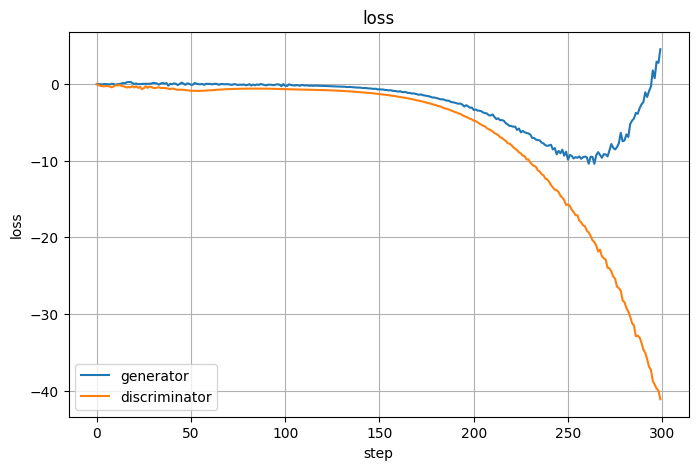

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=loss, x="step", y="value_g", ax=ax, label="generator")
sns.lineplot(data=loss, x="step", y="value_d", ax=ax, label="discriminator")
ax.set_xlabel("step")
ax.set_ylabel("loss")
ax.set_title("loss")
ax.grid()
plt.show()

## 生成画像とAttention Mapの確認

完璧ではないものの、Generatorは「それっぽい画像」をうまく生成できていることが確認できる。モード崩壊も見られない。

Generatorの中心位置に対するAttention Mapも確認する。step数が小さいときには、全体がまばらに強調されてしまっている。それが、学習に進むにつれて、強調される部分が限定されてくる。

Discriminatorは、Attention Mapにはっきりと数字が現れるように強調がされており、うまく学習できていることが確認できる。

In [8]:
num_image = 10
log_dir = sorted(glob.glob("./sagan/*"))[-1]
path = glob.glob(os.path.join(log_dir, "logs", "events.out.tfevents.*"))[0]
acc = EventAccumulator(path, size_guidance={IMAGES: num_image})
acc.Reload()
display(acc.Tags())

{'images': ['Images/discriminator/input',
  'Images/generator',
  'Images/generator/attention_map_4',
  'Images/generator/attention_map_6',
  'Images/discriminator/attention_map_7',
  'Images/discriminator/attention_map_10'],
 'audio': [],
 'histograms': [],
 'scalars': [],
 'distributions': [],
 'tensors': ['Config/discriminator/text_summary',
  'Config/generator/text_summary',
  'Config/Common/text_summary'],
 'graph': False,
 'meta_graph': False,
 'run_metadata': []}

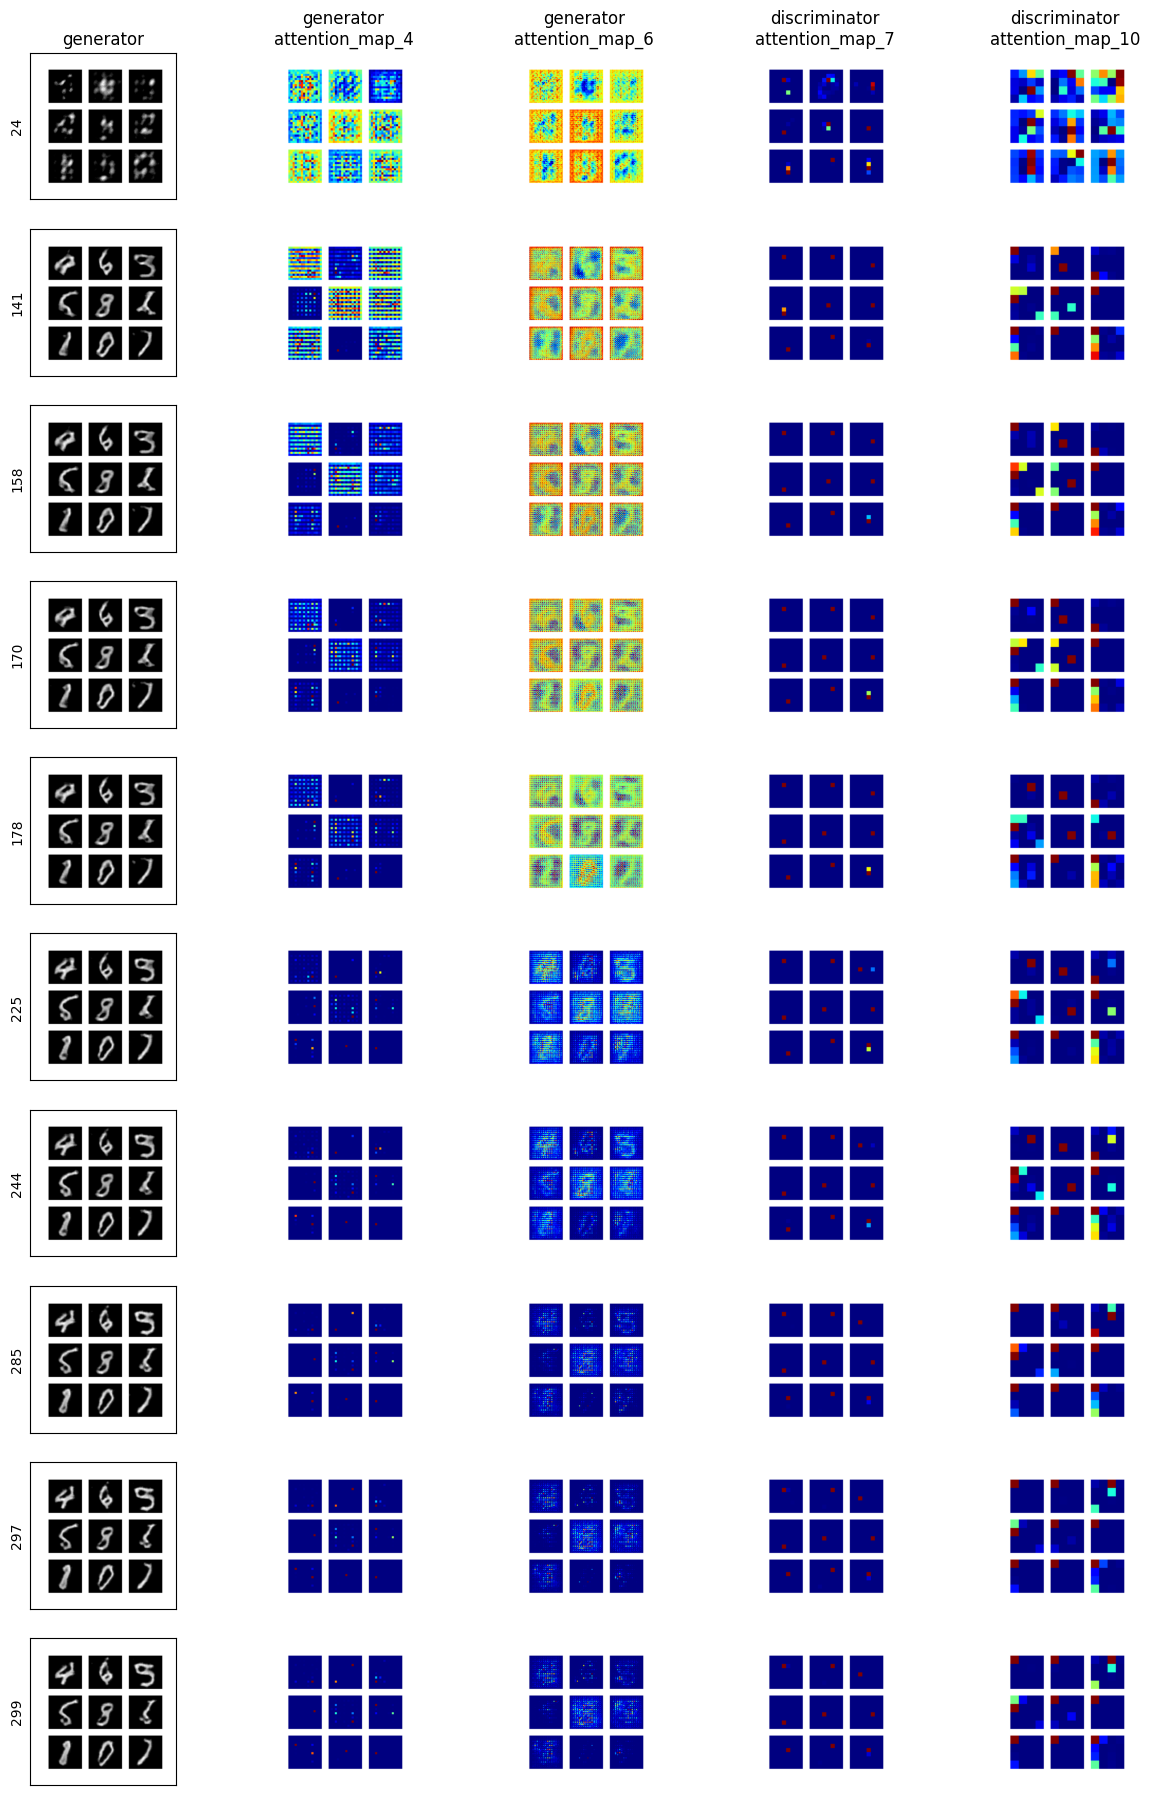

In [9]:
image_labels = [
    label for label in acc.Tags()["images"] if label != "Images/discriminator/input"
]
fig, axes = plt.subplots(
    num_image, len(image_labels), figsize=(num_image * 1.5, len(image_labels) * 4.5)
)
for i, label in enumerate(image_labels):
    for j in range(num_image):
        # axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title(label.replace("Images/", "").replace("/", "\n"))
        if i == 0:
            axes[j, i].set_ylabel(acc.Images(label)[j].step)
            axes[j, i].set_xticks([])
            axes[j, i].set_yticks([])
        else:
            axes[j, i].axis("off")
        image = Image.open(io.BytesIO(acc.Images(label)[j].encoded_image_string))
        axes[j, i].imshow(image)

## 参考文献

- [つくりながら学ぶ！PyTorchによる発展ディープラーニング | 小川 雄太郎 | 工学 | Kindleストア | Amazon](https://www.amazon.co.jp/%E3%81%A4%E3%81%8F%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6%EF%BC%81PyTorch%E3%81%AB%E3%82%88%E3%82%8B%E7%99%BA%E5%B1%95%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0-%E5%B0%8F%E5%B7%9D-%E9%9B%84%E5%A4%AA%E9%83%8E-ebook/dp/B07VPDVNKW/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=39VBRPTDUUH0F&keywords=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch&qid=1701503265&sprefix=%E4%BD%9C%E3%82%8A%E3%81%AA%E3%81%8C%E3%82%89%E5%AD%A6%E3%81%B6+pytorch%2Caps%2C221&sr=8-1)
- [[1802.05957] Spectral Normalization for Generative Adversarial Networks](https://arxiv.org/abs/1802.05957)